Try training on GHZ state using data in random bases

In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor

In [3]:
L=2
local_dim=2
bond_dim=2

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

Samples_tr: lists indices of the observed basis states at each measurement.

settings: array of corresponding angles

In [5]:
fname_settings = "test_datasets/settings_ghz_plus_random_basis_L=%d.npy"%L
fname_samples = "test_datasets/samples_ghz_plus_random_basis_L=%d.npy"%L
samples = np.load(fname_samples)
samples_tr = torch.tensor((1-samples)/2).to(torch.long)
settings = np.load(fname_settings)

In [6]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [7]:
from qtools import pauli_exp

In [8]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [9]:
from torch.utils.data import TensorDataset, DataLoader

In [10]:
from models import MeasurementDataset, ComplexTensor

In [11]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

In [12]:
batch_size = 1028
lr = 1e-2

In [13]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [14]:
losses = []

Number of epochs of training

In [15]:
eps = 25

In [16]:
nstep=1

In [17]:
max_sv = None
cutoff=1e-8

In [18]:
amp1 = []
amp2 = []

In [19]:
s2_schedule = np.concatenate([np.linspace(.1, 0, (eps-1) * len(dl)), np.zeros(len(dl))])

In [20]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        #get torch tensors representing measurement outcomes, and corresponding local unitaries
        spinconfig = inputs['samples']
        rot = inputs['rotations']
        rotations = ComplexTensor(rot['real'], rot['imag'])
        
        s2_penalty = s2_schedule[ep*len(dl) + step]
        #forward sweep across the chain
        for i in range(L-1):
            for __ in range(nstep):
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='left',max_sv_to_keep=max_sv, 
                                       learning_rate=lr, s2_penalty=s2_penalty)   
        for i in range(L-2, -1,-1):
            for __ in range(nstep):
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='right',max_sv_to_keep=max_sv, 
                                       learning_rate=lr, s2_penalty=s2_penalty)   
        with torch.no_grad():
            losses.append(psi.nll_loss(spinconfig,rotation=rotations))
            
        #check the relative phase between the two relevant basis states
        s1 = torch.tensor([1,0]* (L//2),dtype=torch.long)
        s2 = torch.tensor([0,1] * (L//2),dtype=torch.long)
        a1 = psi.amplitude_normalized(s1).numpy().item()
        a2 = psi.amplitude_normalized(s2).numpy().item()
        amp1.append(a1)
        amp2.append(a2)
        
        
    print("finished epoch %d" % ep)

        

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4
finished epoch 5
finished epoch 6
finished epoch 7
finished epoch 8
finished epoch 9
finished epoch 10
finished epoch 11
finished epoch 12
finished epoch 13
finished epoch 14
finished epoch 15
finished epoch 16
finished epoch 17
finished epoch 18
finished epoch 19
finished epoch 20
finished epoch 21
finished epoch 22
finished epoch 23
finished epoch 24
finished epoch 25
finished epoch 26
finished epoch 27
finished epoch 28
finished epoch 29
finished epoch 30
finished epoch 31
finished epoch 32
finished epoch 33
finished epoch 34
finished epoch 35
finished epoch 36
finished epoch 37
finished epoch 38
finished epoch 39
finished epoch 40
finished epoch 41
finished epoch 42
finished epoch 43
finished epoch 44
finished epoch 45
finished epoch 46
finished epoch 47
finished epoch 48
finished epoch 49


In [21]:
import matplotlib.pyplot as plt

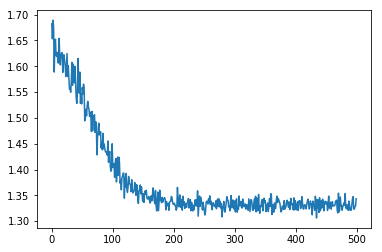

In [22]:
%matplotlib inline
plt.plot(losses)

In [23]:
amp1 = np.asarray(amp1)
amp2 = np.asarray(amp2)
phi1 = np.angle(amp1,deg=True)
phi2 = np.angle(amp2,deg=True)
dphi = phi1-phi2

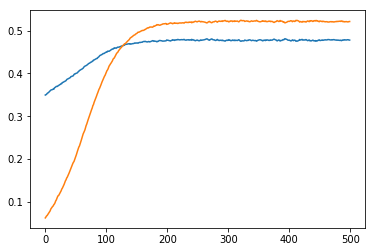

In [24]:
fig, ax = plt.subplots()
plt.plot(np.abs(amp1)**2, label="10")
plt.plot(np.abs(amp2)**2, label="01")

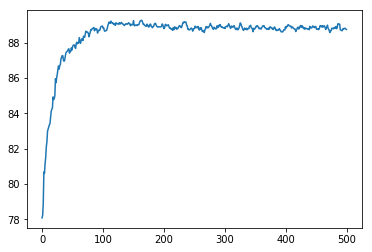

In [25]:
fig, ax = plt.subplots()
plt.plot(dphi)

In [26]:
from tools import generate_binary_space

In [27]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [28]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1]) has probability 0.0004
tensor([1, 0]) has probability 0.4780
tensor([0, 1]) has probability 0.5215
tensor([0, 0]) has probability 0.0000


In [29]:
with torch.no_grad():
    for i in range(len(basis)):
        a = psi.amplitude_normalized(basis[i])
        print("{0} has amplitude {1:.4f} + i{2:.4f}".format(basis[i], a.real.item(), a.imag.item()))

tensor([1, 1]) has amplitude -0.0086 + i-0.0191
tensor([1, 0]) has amplitude 0.3094 + i-0.6183
tensor([0, 1]) has amplitude -0.6386 + i-0.3372
tensor([0, 0]) has amplitude -0.0014 + i0.0067
